# Statistical model
1. Single LinReg
2. One LinReg per model
3. One LinReg per model but include operators in training data.

In [49]:
# Load data
from src.util import read_results
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from src.util import model_operators, train_and_score, train_test_validate_split, feature_transform_pipe, eval_result
import numpy as np
result_df = read_results(from_parquet=True)
result_df.head()
%load_ext autoreload
%autoreload 2
plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

from src.util import all_cat_features
list_features = [x for x in result_df.columns if isinstance(result_df[x].iloc[0], np.ndarray)]
print(list_features)
result_df = result_df.drop(columns=list_features)
cat_features = list(set(result_df.columns).intersection(all_cat_features))
result_df[cat_features] = result_df[cat_features].astype(str)

train, test, validate = train_test_validate_split(result_df)
estimator_results = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['features', 'r_S', 'c_S', 'nnz_S', 'sparsity_S', 'morpheusfi_eis', 'morpheusfi_nis']
train set:
	Records: 189256
	Positive (speedup > 1 with factorizing)/Negative: 36554/152702 = 0.24 s
	Dataset types: ['synthetic']
\Compute Units: ['v100' '2080' 'CPU 16c' 'a40' 'CPU 08c' '1080' 'CPU 32c']
test set:
	Records: 81110
	Positive (speedup > 1 with factorizing)/Negative: 15420/65690 = 0.23 s
	Dataset types: ['synthetic']
\Compute Units: ['2080' 'CPU 08c' 'CPU 32c' 'a40' 'v100' 'CPU 16c' '1080']
validate set:
	Records: 42183
	Positive (speedup > 1 with factorizing)/Negative: 5569/36614 = 0.15 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


## Stat.1 Single LinReg


In [50]:
all_features = ['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'compute_unit', 'complexity_ratio',
       'times_mean', 'dataset_type', 'compute_type', 'label', 'features',
       'parallelism', 'mem_mat_read', 'mem_mat_write', 'mem_fac_read',
       'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat', 'comp_rmm_mat',
       'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac', 'comp_mat_col_major',
       'comp_fac_col_major', 'comp_scalar_dense', '13', '14',
       'comp_matrix_dense', 'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis',
       'gpu__architecture', 'gpu__number_of_sm', 'gpu__cores',
       'gpu_cache_size_l1', 'gpu_cache_size_l2', 'gpu_clock_speed_base',
       'gpu_clock_speed_max_boost', 'gpu_memory_bus_width', 'gpu_memory_size',
       'gpu_memory_clock', 'gpu_memory_bandwidth',
       'gpu_processing_power_half_precision',
       'gpu_processing_power_single_precision',
       'gpu_processing_power_double_precision', 'materialized_times_mean',
       'time_saved']
meta_features = ['dataset_type', 'features', 'comp_ratio', 'tr', 'fr', 'compute_unit', 'materialized_times_mean']
dep = ['speedup', 'times_mean', 'label', 'time_saved','materialized_times_mean']
indep = list(set(all_features).intersection(result_df.columns) - set(dep) - set(meta_features))

2024-03-21 10:04:21.547 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']


2024-03-21 10:04:26.261 | INFO     | src.util:eval_model:383 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['mem_read_rowsum', 'comp_scalar_fac', 'mem_mat_read', 'nnz_S_sum',
       'gpu_memory_size', 'gpu__cores',
       'gpu_processing_power_single_precision', 'comp_rowsum', 'comp_colsum',
       'complexity_ratio', 'comp_matrix_dense', 'mem_write_rowsum',
       'gpu_memory_bandwidth', 'gpu_cache_size_l1', 'nnz_T',
       'comp_fac_col_major', 'mem_read_colsum', 'FR', 'comp_fac',
       'mem_write_scalar_dense', 'cardinality_S', '14', 'gpu__number_of_sm',
       'comp_rmm_fac', '24', 'comp_rmm_mat', 'cardinality_T', 'operator',
       'join', 'mem_mat_write', 'gpu_clock_speed_base', 'TR', 'c_T', 'r_T',
       'gpu__architecture', 'morpheusfi_q', 'comp_scalar_dense', 'parallelism',
       'sparsity_T', 'selectivity', 'comp_mat_col_major', '13',
       'morpheusfi_ns', 'mem_read_matrix_dense', 'comp_lmm_mat',
       'gpu_cache_size_l2', 'mem_write_col

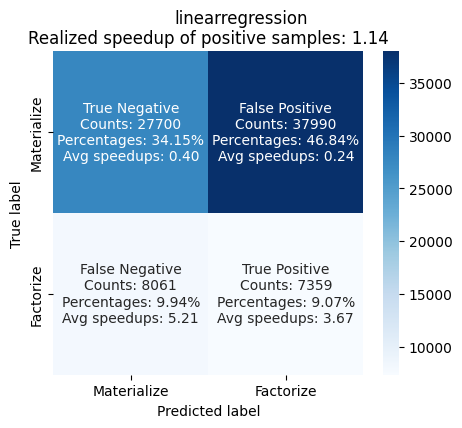

In [51]:
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

lin_reg_combined = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True)

# Test only on models
locator = test[test.operator.isin(model_operators)].index
y_pred = pd.Series(lin_reg_combined.predict(X_test.loc[locator]), index=X_test.loc[locator].index)
resul = eval_result(y_test.loc[locator], y_pred > 1.2, full_dataset=test.loc[locator], model_name='STAT.1')

estimator_results['STAT.1'] = resul[0]

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

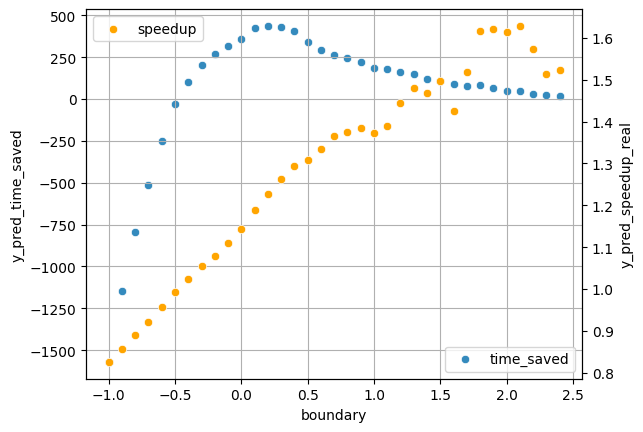

In [52]:
from src.util import eval_result

def plot_boundary(y_true, y_pred, lower=-1., upper=1., step=0.1):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x= np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred = y_pred > boundary, full_dataset=test)
        results.append({'boundary': boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax=sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label='time_saved')
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label='speedup', color='orange')
    ax.grid()
    ax.legend(loc='lower right')
    return ax
plot_boundary(y_test, pd.Series(lin_reg_combined.predict(X_test), index=X_test.index), upper=2.5)

## STAT.2 Single linreg on only Models

2024-03-21 10:04:32.884 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-21 10:04:33.665 | INFO     | src.util:eval_model:383 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['mem_read_rowsum', 'comp_scalar_fac', 'mem_mat_read', 'nnz_S_sum',
       'gpu_memory_size', 'gpu__cores',
       'gpu_processing_power_single_precision', 'comp_rowsum', 'comp_colsum',
       'complexity_ratio', 'comp_matrix_dense', 'mem_write_rowsum',
       'gpu_memory_bandwidth', 'gpu_cache_size_l1', 'nnz_T',
       'comp_fac_col_major', 'mem_read_colsum', 'FR', 'comp_fac',
       'mem_write_scalar_dense', 'cardinality_S', '14', 'gpu__number_of_sm',
       'comp_rmm_fac', '24', 'comp_rmm_mat', 'cardinality_T', 'operator',
       'join', 'mem_mat_write', 'gpu_clock_speed_base', 'TR', 'c_T', 'r_T',
       'gpu__architecture', 'morpheusfi_q', 'comp_scalar_dense', 'parallelism',
       'sparsity_T', 'selectivity', 'comp_mat_col_major', '13',
       'morpheusfi_ns', 'mem_read_matrix_dense', 'comp_lmm_mat',
       'gpu_cache_size_l2', 'mem_write_col

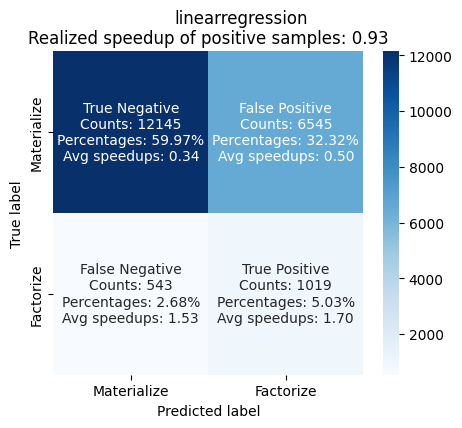

In [53]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]
lin_reg_model = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True)

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

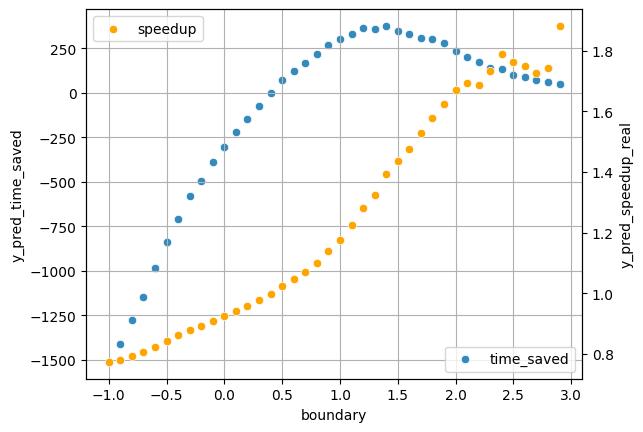

In [54]:
y_pred = pd.Series(lin_reg_model.predict(X_test), index=X_test.index)
plot_boundary(y_test, y_pred, upper=3.0)

In [55]:
estimator_results['STAT.2'] = eval_result(y_test, y_pred>1.5, full_dataset=test, model_name='STAT.2')[0]

## STAT.3 Linear Regression predict runtime for F & M
Two regression, predict runtime for both F and M. Select lowest

In [56]:
from src.analytical_model import create_linreg_ensemble, predict_linreg_ensemble


train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
# Add a constant column to the dataframes
train['constant'] = 1
test['constant'] = 1
validate['constant'] = 1

X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [57]:
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='constant',
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by='constant')

2024-03-21 10:04:36.200 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by constant
2024-03-21 10:04:36.213 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']


2024-03-21 10:04:37.655 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:38.780 | INFO     | src.analytical_model:create_linreg_ensemble:125 - Created a linear regression ensemble for the analytical model with 2 models
2024-03-21 10:04:38.783 | INFO     | src.analytical_model:predict_linreg_ensemble:68 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

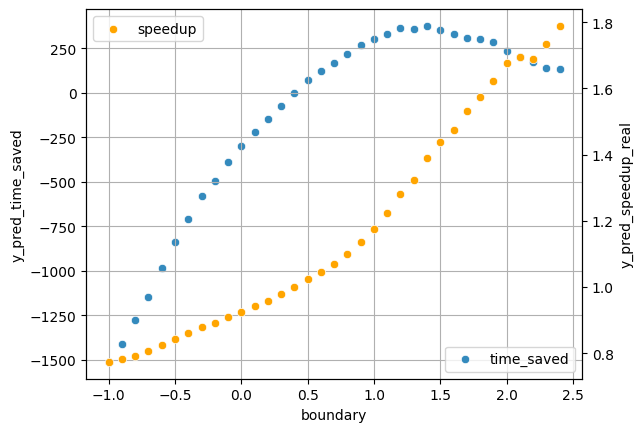

In [58]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)

In [59]:
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 1.4, full_dataset=test)
estimator_results['STAT.3'] = res[0]

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat.4 Separate regressors for each model type

## Stat.4 Separate regressors for each model type

In [60]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='operator',
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, [y_test.name], split_by='operator')

2024-03-21 10:04:42.355 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by operator
2024-03-21 10:04:42.367 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:42.517 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-21 10:04:42.682 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:42.850 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:43.010 | INFO     | src.analytical_model:create_linreg_ensemble:125 - Created a linear regression ensemble for the analytical model with 4 models
2024-03-21 10:04:43.012 | INFO     | src.analytical_model:predict_linreg_ensemble:68 - Predicting results of the analytical model using a linear regression ensemble


In [61]:
res = eval_result(y_test, y_pred = pred.time_saved, full_dataset=test)
estimator_results['STAT.4'] = res[0]

2024-03-21 10:04:43.262 | INFO     | src.util:eval_result:427 - Assuming y_pred is 'time_saved', converting to bool


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat. 5 split CPU and GPU

In [62]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

split_by = 'compute_type'
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, [y_test.name], split_by=split_by)

2024-03-21 10:04:43.524 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by compute_type
2024-03-21 10:04:43.535 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-21 10:04:43.805 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:44.187 | INFO     | src.analytical_model:create_linreg_ensemble:125 - Created a linear regression ensemble for the analytical model with 2 models
2024-03-21 10:04:44.188 | INFO     | src.analytical_model:predict_linreg_ensemble:68 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

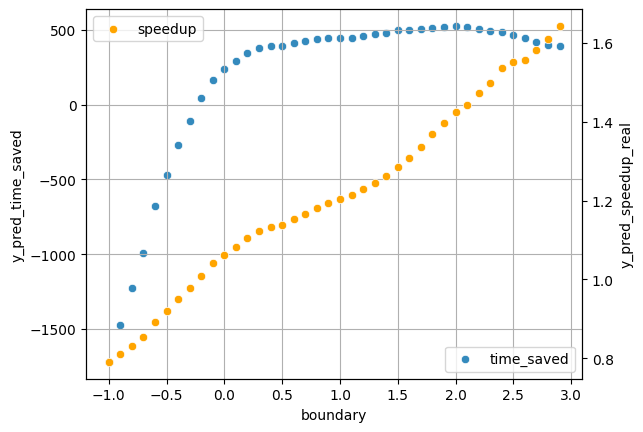

In [63]:
res = eval_result(y_test, y_pred = pred.time_saved > 0.7, full_dataset=test)
estimator_results['STAT.5'] = res[0]
res[0]
plot_boundary(y_test, pred.time_saved, upper=3.0)

## Stat.6 Split by F,M,operator

In [64]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

2024-03-21 10:04:47.738 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by ['operator']
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/analytical_model.py:101: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (split_value_tuple), group_df in df.groupby(split_by):
2024-03-21 10:04:47.752 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-21 10:04:47.925 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:48.136 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:48.332 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:48.526 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:48.736 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:48.906 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:49.085 | INFO     | src.util:feature_transform_pipe:357 - c

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

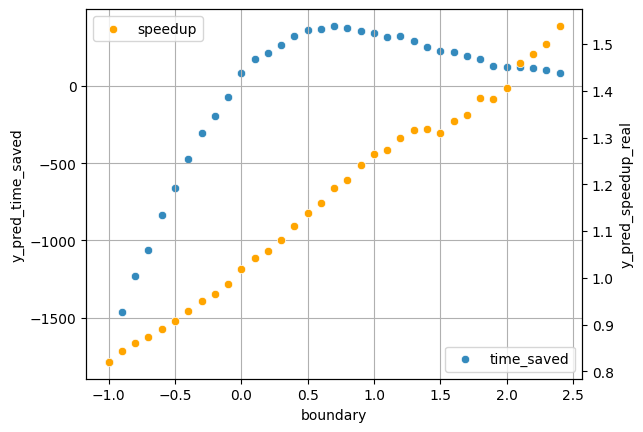

In [65]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.6, full_dataset=test)
estimator_results['STAT.6'] = res[0]

## Stat.7 Split by F,M,operator

In [66]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator', 'compute_type']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

2024-03-21 10:04:52.777 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by ['operator', 'compute_type']
2024-03-21 10:04:52.795 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:52.871 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-21 10:04:53.068 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:53.174 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:53.281 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:53.366 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:53.453 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:53.558 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:53.661 | INFO     | src.util:feature_transform_pipe:357 - c

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

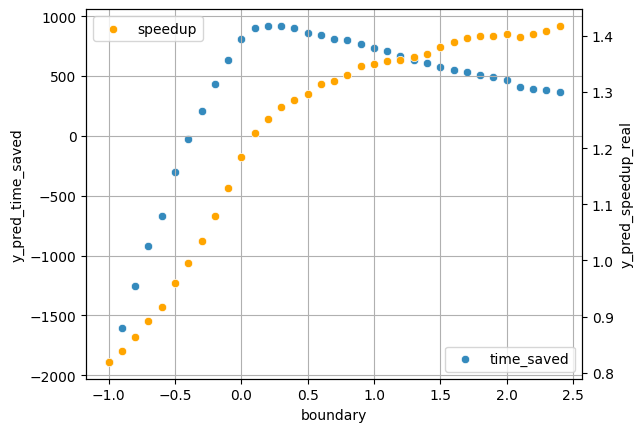

In [67]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test)
estimator_results['STAT.7'] = res[0]

## STAT.8 (not included)

In [68]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['compute_type']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

2024-03-21 10:04:57.955 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by ['compute_type']
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/analytical_model.py:101: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (split_value_tuple), group_df in df.groupby(split_by):
2024-03-21 10:04:57.969 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-21 10:04:58.295 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:58.599 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:59.006 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'join', 'compute_type', 'gpu__architecture']
2024-03-21 10:04:59.402 | INFO     | src.analytical_model:create_linreg_ensemble:125 - Created a linear regression ensemble for the analytical model with 4 models
2024-03-21 10:04:59.404 | INFO     | src.analytical_model:predict_linreg_ensemble:68 - Predicting results of the analytical model using a linear regression ensemble
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/analytical_model.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a gr

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

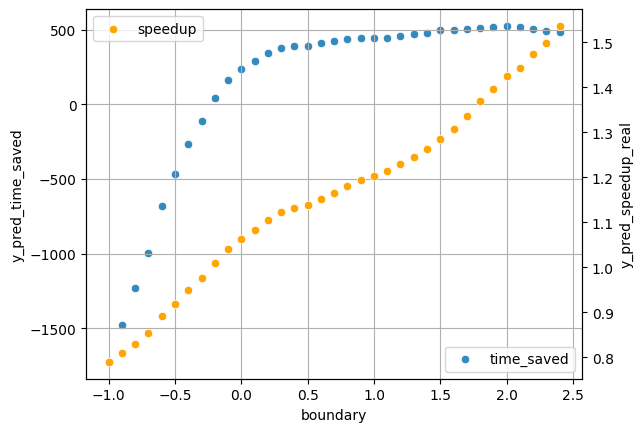

In [69]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.2, full_dataset=test)
# estimator_results['STAT.8'] = res[0]

# Analysis

In [101]:
import matplotlib
colors = ['#F5F5F5', '#DAE8FC', '#D5E8D4', '#FFE6CC', '#FFF2CC','#F8CECC', '#E1D5E7']
pal = sns.color_palette([matplotlib.colors.to_rgba(x) for x in colors])
pal

[(0.9607843137254902, 0.9607843137254902, 0.9607843137254902),
 (0.8549019607843137, 0.9098039215686274, 0.9882352941176471),
 (0.8352941176470589, 0.9098039215686274, 0.8313725490196079),
 (1.0, 0.9019607843137255, 0.8),
 (1.0, 0.9490196078431372, 0.8),
 (0.9725490196078431, 0.807843137254902, 0.8),
 (0.8823529411764706, 0.8352941176470589, 0.9058823529411765)]

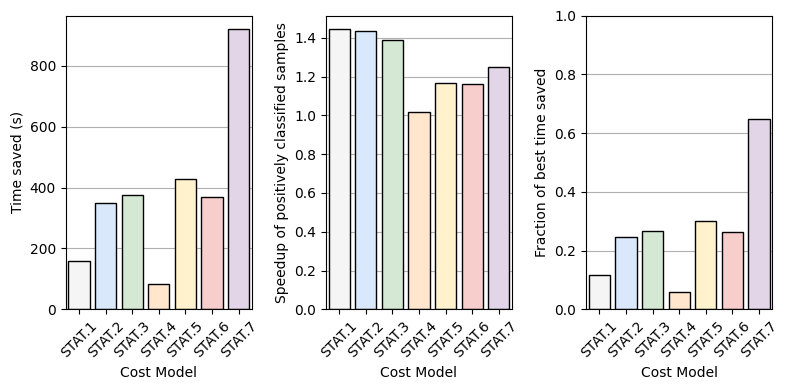

In [102]:
resdf = pd.DataFrame(estimator_results.values())
resdf['Model'] = estimator_results.keys()
resdf = resdf.merge(pd.json_normalize(resdf.speedup), left_index=True, right_index=True)
resdf['fraction_of_optimal_time_saved'] = resdf.y_pred_time_saved / resdf.y_true_time_saved
palette = []
f, axs = plt.subplots(1,3, figsize=(8,4))
labels = ["Time saved (s)", "Speedup of positively classified samples", "Fraction of best time saved"]
for ax, var, label in zip(axs, ['y_pred_time_saved', 'y_pred_speedup_real', 'fraction_of_optimal_time_saved'], labels):
    sns.barplot(data=resdf, x='Model', y=var, ax=ax, palette=pal, saturation=1, edgecolor = "black", linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    ax.set_xlabel("Cost Model")
    if var =='fraction_of_optimal_time_saved':
        ax.set_ylim(0, 1)
f.tight_layout()
f.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/stat-models-compare.pdf", bbox_inches='tight')

In [103]:
resdf

,accuracy,precision,recall,f1,speedup,Model,y_true_mat_time,y_true_fact_time,y_true_best_time,y_true_time_saved,...,y_pred_fact_time,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_time_saved
0,0.918422,0.348178,0.053817,0.093225,"{'y_true_mat_time': 4766.433451637602, 'y_true...",STAT.1,4766.433452,3374.823689,3374.823689,1391.609763,...,361.006905,342.721918,160.062007,1.123694,1.443377,"(86, 1.7097255398598945)","(161, 0.8106579420748634)","(18749, 0.39442381798351567)","(1512, 1.6328442916866577)",0.115019
1,0.916749,0.435282,0.266965,0.330952,"{'y_true_mat_time': 4733.428332464589, 'y_true...",STAT.2,4733.428332,3317.907400,3317.907400,1415.520933,...,798.023443,743.636754,349.140972,1.062991,1.437507,"(417, 1.658471734352826)","(541, 0.6039968992059881)","(18149, 0.3878575967962406)","(1145, 1.637855750265091)",0.246652
2,0.869593,0.070120,0.056338,0.062478,"{'y_true_mat_time': 4733.428332464589, 'y_true...",STAT.3,4733.428332,3317.907400,3317.907400,1415.520933,...,958.010373,883.197322,374.736536,0.975271,1.391161,"(488, 1.614039460746396)","(767, 0.5688581016648508)","(17923, 0.38663592494272553)","(1074, 1.6566818346689165)",0.264734
3,0.687586,0.075539,0.271447,0.118188,"{'y_true_mat_time': 4733.428332464589, 'y_true...",STAT.4,4733.428332,3317.907400,3317.907400,1415.520933,...,4598.230323,3650.170689,82.039830,0.713208,1.017842,"(1045, 1.614380779633276)","(4568, 0.5070506132748894)","(14122, 0.3575826827139014)","(517, 1.7019335252647658)",0.057957
4,0.850435,0.079174,0.088348,0.083510,"{'y_true_mat_time': 4733.428332464589, 'y_true...",STAT.5,4733.428332,3317.907400,3317.907400,1415.520933,...,2561.304927,2278.600435,426.463962,1.055870,1.166503,"(739, 1.5633929321437174)","(1004, 0.6823042123176253)","(17686, 0.3777539532714302)","(823, 1.7151642410989674)",0.301277
5,0.853200,0.078806,0.084507,0.081557,"{'y_true_mat_time': 4733.428332464589, 'y_true...",STAT.6,4733.428332,3317.907400,3317.907400,1415.520933,...,2308.057815,1937.482027,370.159452,0.864665,1.160377,"(518, 1.6505275172155847)","(1157, 0.512827008120069)","(17533, 0.38628010028691556)","(1044, 1.6398029629894488)",0.261501
6,0.831622,0.074586,0.103713,0.086770,"{'y_true_mat_time': 4733.428332464589, 'y_true...",STAT.7,4733.428332,3317.907400,3317.907400,1415.520933,...,3645.606645,3325.223813,919.165907,1.163186,1.252130,"(1060, 1.7687702880513037)","(1112, 0.5859202756985272)","(17578, 0.3819801172004009)","(502, 1.378547892319274)",0.649348
